#Init (Mount Drive, install pyulog)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyulog

#Convert .ulg to CSVs

##Option 1

In [ ]:
import subprocess
import os
import pandas
import os
import numpy as np

for parent_path in os.listdir('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/'):

  #Change to DOS when needed
  # for addition in ['Normal_GPS', 'GPS']:
  for addition in ['HackRF', 'Keysight 1', 'Keysight 2']:
    # if "PX4" not in parent_path:
    #   continue
    if addition not in os.listdir('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/' + parent_path + '/'):
      path = '/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/' + parent_path + '/'
    else:
      path = '/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/' + parent_path + '/' + addition + '/'
    print(path)

    filepath = ''
    os.chdir(path)

    for x in os.listdir("./"):
      print(x)
      if ".ulg" in x:
        filepath = x
        break
    if not os.path.isdir(path + 'CSVs'):
      os.mkdir(path + 'CSVs')
    os.chdir(path)
    subprocess.run(["ulog2csv", "-o", path + "CSVs/", path + filepath])

    # csv_list = ['actuator_controls', 'actuator_output', 'airspeed',
    #         'ekf2_innovations', 'estimator_status', 'multirotor_motor_limits',
    #         'rate_ctrl_status', 'sensor_combined', 'telemetry_status', 'angular_velocity',
    #         'vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0',
    #         'magnetometer', 'vehicle_rates_setpoint']
    #GPS
    csv_list = ['vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0']
    #DOS
    #csv_list = ['vehicle_status_0', 'telemetry_status']
    # csv_list_gpsekf = ['actuator_controls', 'actuator_output', 'airspeed',
    #             'ekf2_innovations', 'estimator_status', 'angular_velocity',
    #             'vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0']

    existing_csv_list = os.listdir(path + "CSVs/")
    print(existing_csv_list)

    final_df = pandas.DataFrame()
    final_df_gps = pandas.DataFrame()
    final_df_gpsekf = pandas.DataFrame()


    for csv in csv_list:
        for exist_csv in existing_csv_list:
            if csv in exist_csv:
                temp_df = pandas.read_csv(path + "CSVs/" + exist_csv)
                #print(temp_df)
                if len(final_df.columns) == 0:
                    final_df = temp_df
                else:
                    final_df = final_df.merge(temp_df, how='outer',left_on='timestamp', right_on='timestamp')
                    #print(final_df)
                # if csv in csv_list_gps:
                #     if len(final_df_gps.columns) == 0:
                #         final_df_gps = temp_df
                #     else:
                #         final_df_gps = final_df_gps.merge(temp_df, how='outer', left_on='timestamp', right_on='timestamp')
                        # print(final_df)
                # if csv in csv_list_gpsekf:
                #     if len(final_df_gpsekf.columns) == 0:
                #         final_df_gpsekf = temp_df
                #     else:
                #         final_df_gpsekf = final_df_gpsekf.merge(temp_df, how='outer', left_on='timestamp', right_on='timestamp')
                #         # print(final_df)
                break

    #print(final_df.sort_values('timestamp'))

    final_df = final_df.sort_values('timestamp')
    final_df = final_df.set_index('timestamp')
    # final_df_gps = final_df_gps.sort_values('timestamp')
    # final_df_gps = final_df_gps.set_index('timestamp')
    # final_df_gpsekf = final_df_gpsekf.sort_values('timestamp')
    # final_df_gpsekf = final_df_gpsekf.set_index('timestamp')
    #print(final_df)
    #final_df.to_csv('finaldf.csv')
    #final_df = pandas.read_csv('finaldf.csv')
    final_df = final_df.interpolate(axis=0, method='linear', limit_direction='both')
    #final_df_gps = final_df_gps.interpolate(axis=0, method='linear', limit_direction='both')
    #final_df_gpsekf = final_df_gpsekf.interpolate(axis=0, method='linear', limit_direction='both')
    #print(final_df)

    past = False
    for column in final_df.columns:
        if "timestamp" in column:
            if not past:
                past = True
                continue
            print(column)
            #final_df = final_df.drop(columns=column)
            final_df = final_df.drop(columns=column)
            #if column in final_df_gpsekf.columns:
            #    final_df_gpsekf = final_df_gpsekf.drop(columns=column)

    #print(final_df)

    target_column = []

    print(final_df)
    #Labelling for DoS
    # if addition != 'Normal':
    #   # begin_time = 360008000
    #   # end_time = 367608000
    #   print(final_df.columns)
    #   for index, row, in final_df[['rate_rx']].iterrows():
    #       if int(row['rate_rx']) > 10:
    #         target_column.append('malicious')
    #       else:
    #         target_column.append('benign')
    #   final_df['label'] = target_column

    #Labelling for GPS
    target_column = []
    target_lon, target_lat = 0, 0
    for index, row, in final_df[['lat_x', 'lon_x']].iterrows():
        if len(target_column) == 0:
            print(index, row)
            target_lat = row['lat_x']
            target_lon = row['lon_x']

        if (row['lat_x'] > target_lat + 0.03 or row['lat_x'] < target_lat - 0.03) or (row['lon_x'] > target_lon + 0.03 or row['lon_x'] < target_lon - 0.03):
            #print(row, target_lat, target_lon)
            target_column.append("malicious")
        else:
            target_column.append("benign")
    final_df['label'] = target_column

    # target_column = []
    # target_lon, target_lat = 0, 0
    # for index, row, in final_df_gpsekf[['lat_x', 'lon_x']].iterrows():
    #     if len(target_column) == 0:
    #         print(index, row)
    #         target_lat = row['lat_x']
    #         target_lon = row['lon_x']

    #     if (row['lat_x'] > target_lat + 0.03 or row['lat_x'] < target_lat - 0.03) or (row['lon_x'] > target_lon + 0.03 or row['lon_x'] < target_lon - 0.03):
    #         #print(row, target_lat, target_lon)
    #         target_column.append("malicious")
    #     else:
    #         target_column.append("benign")
    # final_df_gpsekf['label'] = target_column

    #final_df.to_csv('interpol.csv')
    final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
    #final_df_gps = final_df_gps.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
    #final_df_gpsekf = final_df_gpsekf.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
    if not os.path.isdir(path + 'CSVs/Condensed/'):
      os.mkdir(path + 'CSVs/Condensed/')
    final_df.to_csv(path + 'CSVs/Condensed/{}.csv'.format(addition))
    # final_df_gpsekf.to_csv(path + 'CSVs/Condensed/gpsanddroneinfo.csv')
    # final_df.to_csv(path + 'CSVs/Condensed/all.csv')



/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Jamming/
ace-jamming-log_1_2033-8-19-16-46-46.ulg
['ace-jamming-log_1_2033-8-19-16-46-46_yaw_estimator_status_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_hover_thrust_estimate_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_logger_status_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_vehicle_imu_status_1.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_vehicle_imu_status_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_vehicle_imu_1.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_vehicle_imu_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_vehicle_gps_position_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_mag_1.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_mag_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_gyro_1.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_gyro_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_baro_0.csv', 'ace-jamming-log_1_2033-8-19-16-46-46_sensor_accel_1.csv', 'ace-jamm

##Option 2 - 2 steps

In [ ]:
import subprocess
import os
path = '/content/drive/Shared drives/UAV Security Research/Publication/Q2SWinet/Flight Logs/OTU Survey/PX4-H480-SITL/Normal/'
filepath = ''
os.chdir(path)

for x in os.listdir("./"):
  print(x)
  if ".ulg" in x:
    filepath = x
    break
if not os.path.isdir(path + 'CSVs'):
  os.mkdir(path + 'CSVs')
os.chdir(path)
subprocess.run(["ulog2csv", path + filepath])

FileNotFoundError: ignored

In [ ]:
path = '/content/drive/Shared drives/UAV Security Research/Thesis/Flight Logs/ACE/2021-5-11-10-44-56-outdoor-spoof/'

In [ ]:
import pandas
import os
import numpy as np

csv_list = ['actuator_controls', 'actuator_output', 'airspeed',
            'ekf2_innovations', 'estimator_status', 'multirotor_motor_limits',
            'rate_ctrl_status', 'sensor_combined', 'telemetry_status', 'angular_velocity',
            'vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0',
            'magnetometer', 'vehicle_rates_setpoint']
csv_list_gps = ['vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0']
csv_list_gpsekf = ['actuator_controls', 'actuator_output', 'airspeed',
            'ekf2_innovations', 'estimator_status', 'angular_velocity',
            'vehicle_attitude_0', 'global_position_0','gps_position_0', 'local_position_0']

existing_csv_list = os.listdir(path)
print(existing_csv_list)

final_df = pandas.DataFrame()
final_df_gps = pandas.DataFrame()
final_df_gpsekf = pandas.DataFrame()

for csv in csv_list:
    for exist_csv in existing_csv_list:
        if csv in exist_csv:
            temp_df = pandas.read_csv(path + exist_csv)
            #print(temp_df)
            if len(final_df.columns) == 0:
                final_df = temp_df
            else:
                final_df = final_df.merge(temp_df, how='outer',left_on='timestamp', right_on='timestamp')
                #print(final_df)
            if csv in csv_list_gps:
                if len(final_df_gps.columns) == 0:
                    final_df_gps = temp_df
                else:
                    final_df_gps = final_df_gps.merge(temp_df, how='outer', left_on='timestamp', right_on='timestamp')
                    # print(final_df)
            if csv in csv_list_gpsekf:
                if len(final_df_gpsekf.columns) == 0:
                    final_df_gpsekf = temp_df
                else:
                    final_df_gpsekf = final_df_gpsekf.merge(temp_df, how='outer', left_on='timestamp', right_on='timestamp')
                    # print(final_df)
            break

#print(final_df.sort_values('timestamp'))

final_df = final_df.sort_values('timestamp')
final_df = final_df.set_index('timestamp')
final_df_gps = final_df_gps.sort_values('timestamp')
final_df_gps = final_df_gps.set_index('timestamp')
final_df_gpsekf = final_df_gpsekf.sort_values('timestamp')
final_df_gpsekf = final_df_gpsekf.set_index('timestamp')
#print(final_df)
#final_df.to_csv('finaldf.csv')
#final_df = pandas.read_csv('finaldf.csv')
final_df = final_df.interpolate(axis=0, method='linear', limit_direction='both')
final_df_gps = final_df_gps.interpolate(axis=0, method='linear', limit_direction='both')
final_df_gpsekf = final_df_gpsekf.interpolate(axis=0, method='linear', limit_direction='both')
#print(final_df)


for column in final_df.columns:
    if "timestamp" in column:
        if column == "timestamp":
            continue
        print(column)
        final_df = final_df.drop(columns=column)
        if column in final_df_gps.columns:
            final_df_gps = final_df_gps.drop(columns=column)
        if column in final_df_gpsekf.columns:
            final_df_gpsekf = final_df_gpsekf.drop(columns=column)

#print(final_df)
"""
target_column = []
target_lon, target_lat = 0, 0
for index, row, in final_df_gps[['lat_x', 'lon_x']].iterrows():
    if len(target_column) == 0:
        print(index, row)
        target_lat = row['lat_x']
        target_lon = row['lon_x']

    if (row['lat_x'] > target_lat + 0.03 or row['lat_x'] < target_lat - 0.03) or (row['lon_x'] > target_lon + 0.03 or row['lon_x'] < target_lon - 0.03):
        #print(row, target_lat, target_lon)
        target_column.append("malicious")
    else:
        target_column.append("benign")
final_df_gps['label'] = target_column

target_column = []
target_lon, target_lat = 0, 0
for index, row, in final_df[['lat_x', 'lon_x']].iterrows():
    if len(target_column) == 0:
        print(index, row)
        target_lat = row['lat_x']
        target_lon = row['lon_x']


    if (row['lat_x'] > target_lat + 0.03 or row['lat_x'] < target_lat - 0.03) or (row['lon_x'] > target_lon + 0.03 or row['lon_x'] < target_lon - 0.03):
        #print(row, target_lat, target_lon)
        target_column.append("malicious")
    else:
        target_column.append("benign")
final_df['label'] = target_column

target_column = []
target_lon, target_lat = 0, 0
for index, row, in final_df_gpsekf[['lat_x', 'lon_x']].iterrows():
    if len(target_column) == 0:
        print(index, row)
        target_lat = row['lat_x']
        target_lon = row['lon_x']

    if (row['lat_x'] > target_lat + 0.03 or row['lat_x'] < target_lat - 0.03) or (row['lon_x'] > target_lon + 0.03 or row['lon_x'] < target_lon - 0.03):
        #print(row, target_lat, target_lon)
        target_column.append("malicious")
    else:
        target_column.append("benign")
final_df_gpsekf['label'] = target_column
"""

target_column = []
for index, row in final_df_gps.iterrows():
  if row['satellites_used'] == 9:
    target_column.append("malicious")
  else:
    target_column.append("benign")
final_df_gps['label'] = target_column


#final_df.to_csv('interpol.csv')
final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
final_df_gps = final_df_gps.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
final_df_gpsekf = final_df_gpsekf.replace([np.inf, -np.inf], np.nan).dropna(how='any', axis=1)
if not os.path.isdir(path + '/Condensed/'):
  os.mkdir(path + '/Condensed/')
final_df_gps.to_csv(path + '/Condensed/gpsonly.csv')
final_df_gpsekf.to_csv(path + '/Condensed/gpsanddroneinfo.csv')
final_df.to_csv(path + '/Condensed/all.csv')

['log_4_2021-5-11-10-44-56.ulg', 'log_4_2021-5-11-10-44-56_vehicle_imu_status_0.csv', 'log_4_2021-5-11-10-44-56_logger_status_0.csv', 'log_4_2021-5-11-10-44-56_vehicle_magnetometer_0.csv', 'log_4_2021-5-11-10-44-56_actuator_outputs_0.csv', 'log_4_2021-5-11-10-44-56_sensor_gyro_0.csv', 'log_4_2021-5-11-10-44-56_yaw_estimator_status_0.csv', 'log_4_2021-5-11-10-44-56_sensor_accel_1.csv', 'log_4_2021-5-11-10-44-56_actuator_outputs_1.csv', 'log_4_2021-5-11-10-44-56_battery_status_0.csv', 'log_4_2021-5-11-10-44-56_sensor_accel_0.csv', 'log_4_2021-5-11-10-44-56_vehicle_status_0.csv', 'log_4_2021-5-11-10-44-56_multirotor_motor_limits_0.csv', 'log_4_2021-5-11-10-44-56_sensor_mag_0.csv', 'log_4_2021-5-11-10-44-56_telemetry_status_0.csv', 'log_4_2021-5-11-10-44-56_sensor_baro_0.csv', 'log_4_2021-5-11-10-44-56_vehicle_imu_0.csv', 'log_4_2021-5-11-10-44-56_sensor_gyro_1.csv', 'log_4_2021-5-11-10-44-56_hover_thrust_estimate_0.csv', 'log_4_2021-5-11-10-44-56_vehicle_gps_position_0.csv', 'log_4_2021-5

#Graphs - Can skip

In [ ]:
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

3
3
3
3
3


<Figure size 432x288 with 0 Axes>

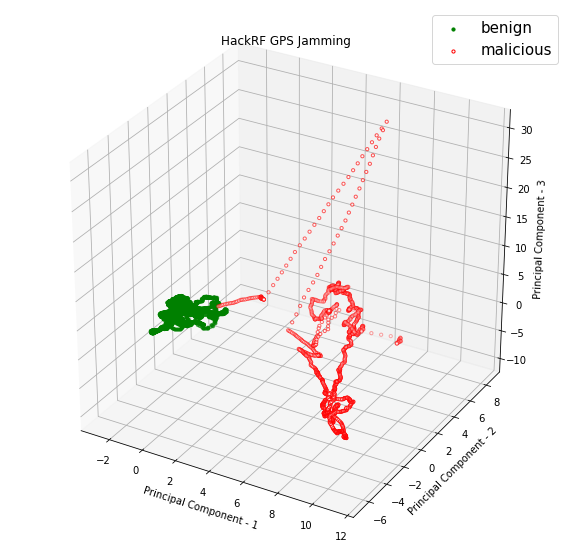

<Figure size 432x288 with 0 Axes>

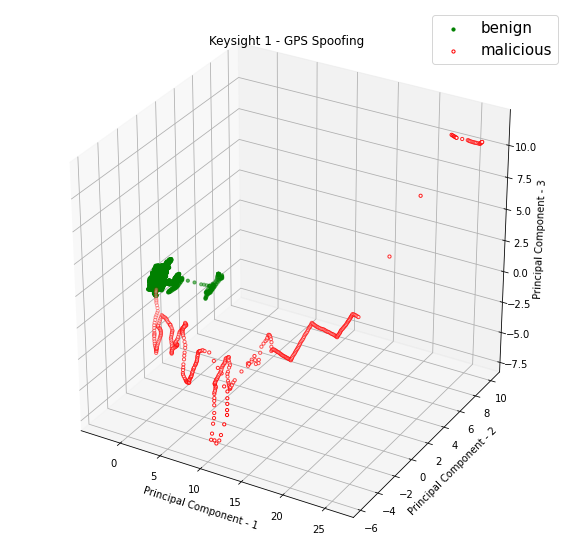

<Figure size 432x288 with 0 Axes>

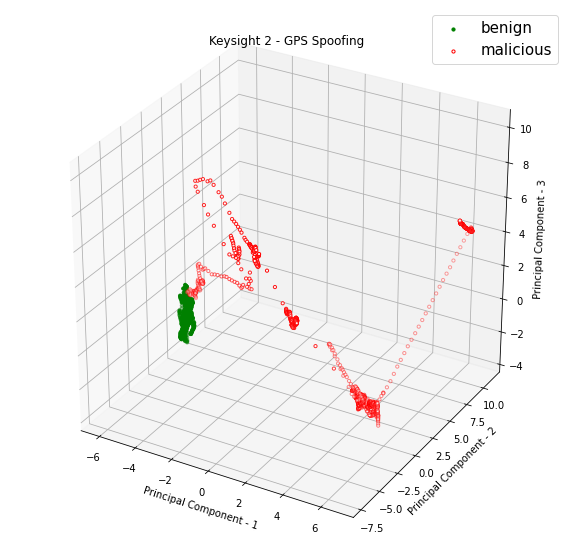

<Figure size 432x288 with 0 Axes>

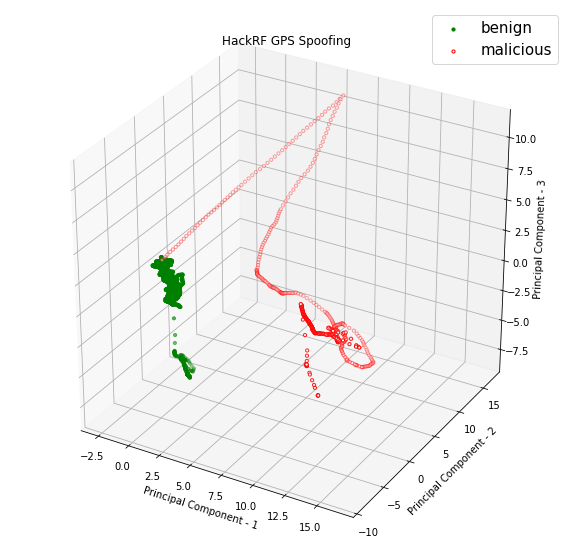

<Figure size 432x288 with 0 Axes>

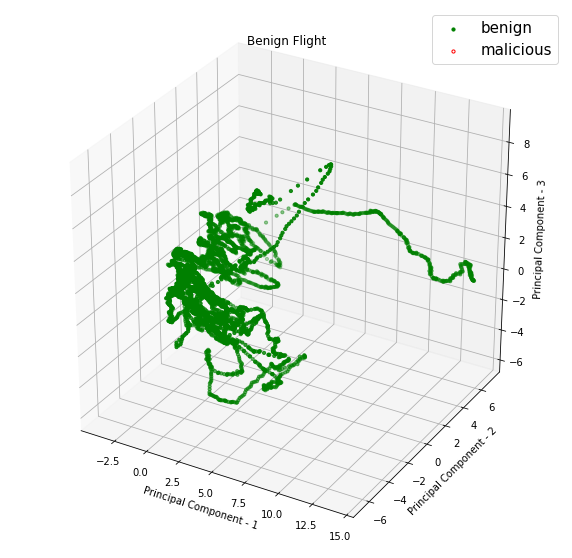

In [ ]:
for parent_path in os.listdir('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/'):
  # if "PX4" not in parent_path:
  #   continue
  paths = []
  if parent_path == 'GPS Spoofing':
    paths.append(('Keysight 1 - GPS Spoofing','/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/Keysight 1/CSVs/Condensed/gpsonly.csv'))
    paths.append(('Keysight 2 - GPS Spoofing','/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/Keysight 2/CSVs/Condensed/gpsonly.csv'))
    paths.append(('HackRF GPS Spoofing','/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/HackRF/CSVs/Condensed/gpsonly.csv'))
  elif parent_path == 'GPS Jamming':
    paths.append(('HackRF GPS Jamming','/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/' + parent_path + '/CSVs/Condensed/gpsonly.csv'))
  else:
    paths.append((parent_path,'/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/' + parent_path + '/CSVs/Condensed/gpsonly.csv'))

  for path in paths:
    df_malicious_flight = pd.read_csv(path[1])
    labels = df_malicious_flight[['label']]
    df_malicious_flight = df_malicious_flight.drop(columns=['timestamp', 'label'])
    x = df_malicious_flight.values
    x = StandardScaler().fit_transform(x) # standardizing the features
    train_pca_gps = PCA(n_components=3)
    train_pc_data = train_pca_gps.fit_transform(x)
    df_malicious_flight_graph = pd.DataFrame(data=train_pc_data, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    df_malicious_flight['label'] = labels

    plt.figure()
    figure = plt.figure(figsize=(10,10))
    ax = figure.add_subplot(111, projection='3d')

    # ax.xticks(fontsize=5)
    # plt.yticks(fontsize=5)
    # plt.zticks(fontsize=5)
    ax.set_xlabel('Principal Component - 1',fontsize=10)
    ax.set_ylabel('Principal Component - 2',fontsize=10)
    ax.set_zlabel('Principal Component - 3',fontsize=10)
    plt.title(path[0])
    targets = ['benign', 'malicious']
    colors = ['g', 'w']
    edge = ['g', 'r']
    for target, color, edge in zip(targets,colors,edge):
        indicesToKeep = df_malicious_flight['label'] == target
        ax.scatter(df_malicious_flight_graph.loc[indicesToKeep, 'principal component 1'], df_malicious_flight_graph.loc[indicesToKeep, 'principal component 2'], df_malicious_flight_graph.loc[indicesToKeep, 'principal component 3'], fc = color, ec = edge, s = 10)

    plt.legend(targets,prop={'size': 15})

#Load CSVs

In [ ]:
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

Total kept components: 14
Most important features:        0                  1
0    PC0                evh
1    PC1      time_utc_usec
2    PC2              lat_y
3    PC3              lat_x
4    PC4          heading_y
5    PC5            z_deriv
6    PC6                 vz
7    PC7                 ax
8    PC8               hdop
9    PC9            vel_m_s
10  PC10               q[2]
11  PC11  jamming_indicator
12  PC12          vel_e_m_s
13  PC13       noise_per_ms
Explained variation per principal component: [0.21610798 0.17464599 0.09475565 0.05861022 0.05213768 0.04175254
 0.03776704 0.03369234 0.03038762 0.02727934 0.02450175 0.0232364
 0.02199081 0.02042742]
0.8572927963879242
Original Values:

df_benign_flight_train: 
         0         1         2         3         4         5         6         7         8         9         10        11        12        13
0  4.103297 -1.921974  7.382074  2.816123  3.493942  1.936596  0.498056 -0.588442  0.424832 -1.199923 -0.093379  0.019694 -

<Figure size 432x288 with 0 Axes>

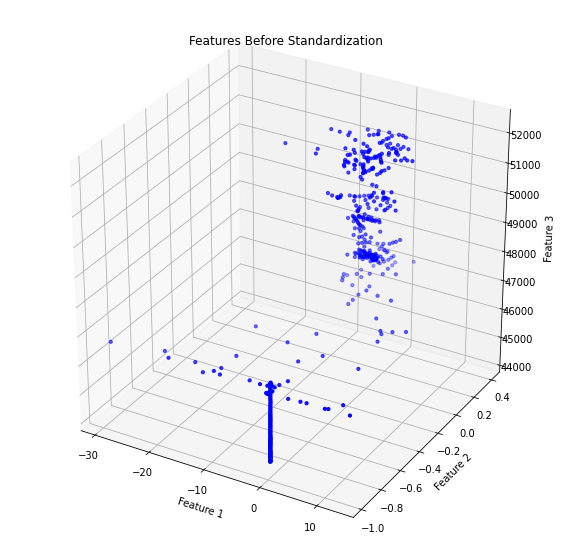

<Figure size 432x288 with 0 Axes>

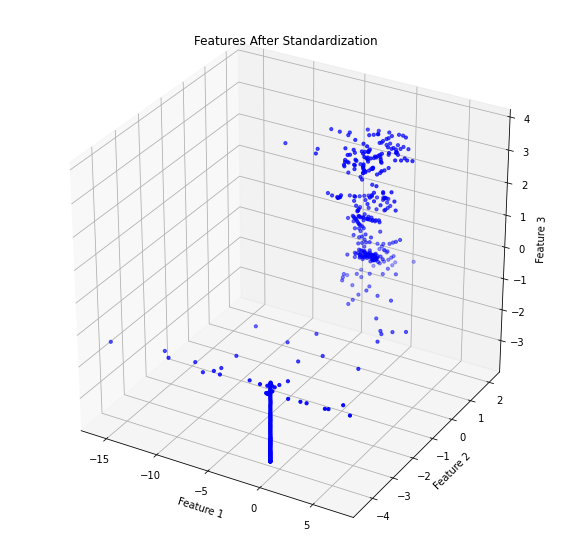

In [ ]:
# load CSVs

df_benign_flight = pd.read_csv( '/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/Benign Flight/CSVs/Condensed/gpsonly.csv')
df_malicious_flight = pd.read_csv('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/HackRF/CSVs/Condensed/gpsonly.csv')

df_benign_flight_train = df_benign_flight.drop(columns=['timestamp', 'label'], errors='ignore')
#print(df_benign_flight_train.columns)
feature_names = df_benign_flight_train.columns
x = df_benign_flight_train.values
x = StandardScaler().fit_transform(x) # standardizing the features
train_pca_gps = PCA(.85)
train_pc_data = train_pca_gps.fit_transform(x)
df_benign_flight_train = pd.DataFrame(data=train_pc_data)

# get features with the most influence
n_pcs = train_pca_gps.components_.shape[0]
print("Total kept components: %s" % n_pcs)
most_important = [np.abs(train_pca_gps.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
important_features = pd.DataFrame(dic.items())
print("Most important features: %s" % important_features)

print('Explained variation per principal component: {}'.format(train_pca_gps.explained_variance_ratio_))
print(sum(train_pca_gps.explained_variance_ratio_))

target_column = df_malicious_flight[['label']]
df_malicious_flight_pred = df_malicious_flight.drop(columns=['timestamp', 'label'], errors='ignore')

#print(df_malicious_flight_pred.columns)
x = df_malicious_flight_pred.values
x = StandardScaler().fit_transform(x) # standardizing the features
test_malicious_nolabel = train_pca_gps.transform(x)
df_malicious_flight_pred = pd.DataFrame(data=test_malicious_nolabel)
df_malicious_flight = pd.DataFrame(data=test_malicious_nolabel)
df_malicious_flight['label'] = target_column

# print the first 5 rows of each dataframe
print("Original Values:\n")
print("df_benign_flight_train: \n%s\n" % df_benign_flight_train[0:5].to_string())
print("df_malicious_flight_pred: \n%s\n" % df_malicious_flight_pred[0:5].to_string())
print("df_malicious_flight: \n%s\n" % df_malicious_flight[0:5].to_string())

df_malicious_flight_graph = pd.read_csv('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/HackRF/CSVs/Condensed/gpsonly.csv')
labels = df_malicious_flight_graph[['label']]
df_malicious_flight_graph = df_malicious_flight_graph.drop(columns=['timestamp', 'label'])

# before standardization
x_graph = df_malicious_flight_graph.values[:, [61, 2, 24]]
df_malicious_flight_graph = pd.DataFrame(data=x_graph, columns = ['feature 1', 'feature 2', 'feature 3'])
plt.figure()
figure = plt.figure(figsize=(10,10))
ax = figure.add_subplot(111, projection='3d')

ax.set_xlabel('Feature 1',fontsize=10)
ax.set_ylabel('Feature 2',fontsize=10,labelpad=5)
ax.set_zlabel('Feature 3',fontsize=10,labelpad=10)
plt.title('Features Before Standardization')
indicesToKeep = df_malicious_flight['label'] == target
ax.scatter(df_malicious_flight_graph.loc[indicesToKeep, 'feature 1'], df_malicious_flight_graph.loc[indicesToKeep, 'feature 2'], df_malicious_flight_graph.loc[indicesToKeep, 'feature 3'], c = 'b', s = 10)

# after standardization
x_graph = df_malicious_flight_graph.values

x_params = df_malicious_flight_graph.values
x_params = StandardScaler()
x_params = x_params.fit(df_malicious_flight_graph.values)
print("MEAN: %s" % x_params.mean_)

x_graph = StandardScaler().fit_transform(x_graph)
x_graph = x[:, [61, 2, 24]]
df_malicious_flight_graph = pd.DataFrame(data=x_graph, columns = ['feature 1', 'feature 2', 'feature 3'])
plt.figure()
figure = plt.figure(figsize=(10,10))
ax = figure.add_subplot(111, projection='3d')

ax.set_xlabel('Feature 1',fontsize=10)
ax.set_ylabel('Feature 2',fontsize=10)
ax.set_zlabel('Feature 3',fontsize=10,labelpad=5)
plt.title('Features After Standardization')
indicesToKeep = df_malicious_flight['label'] == target
ax.scatter(df_malicious_flight_graph.loc[indicesToKeep, 'feature 1'], df_malicious_flight_graph.loc[indicesToKeep, 'feature 2'], df_malicious_flight_graph.loc[indicesToKeep, 'feature 3'], c = 'b', s = 10)

# One Class SVM




In [ ]:
pip install nest_asyncio

In [ ]:
print(f"Benign count: {len(df_benign_flight_train)}")
print(f"Malicious count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'malicious'])}")

# optimization function modified from: https://github.com/spacesense-ai/spacesense/blob/master/spacesense/utils.py
def optimize_OneClassSVM(X, n):
    print('Searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = svm.OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    print("Found: nu = %d, gamma = %f" % (opt_nu, opt_gamma))
    return opt_nu, opt_gamma

nu_opt, gamma_opt = optimize_OneClassSVM(df_benign_flight_train, 20)

Benign count: 6078
Malicious count: 498
Searching for optimal hyperparameters...


KeyboardInterrupt: ignored

In [ ]:
# optimization using GridSearchCV
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import GridSearchCV

x_train = df_malicious_flight.drop(columns=['label'])
y_train = df_malicious_flight[['label']]
y_train = y_train.replace({'benign': 1})
y_train = y_train.replace('malicious', -1)

n = 20
nu = np.linspace(start=1e-5, stop=1e-2, num=n)
gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gamma, 'nu': nu}

scores = ['precision', 'recall']
for score in scores:
    clf = GridSearchCV(svm.OneClassSVM(), tuned_parameters, cv=10, scoring='%s_macro' % score, return_train_score=True)

    clf.fit(x_train, y_train)

    resultDf = pd.DataFrame(clf.cv_results_)
    #print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

Best parameters set found on development set:

{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.01}
Best parameters set found on development set:

{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.01}


              precision    recall  f1-score   support

          -1    1.00000   0.66867   0.80144       498
           1    0.94983   1.00000   0.97427      3124

    accuracy                        0.95445      3622
   macro avg    0.97492   0.83434   0.88786      3622
weighted avg    0.95673   0.95445   0.95051      3622

[[ 333  165]
 [   0 3124]]


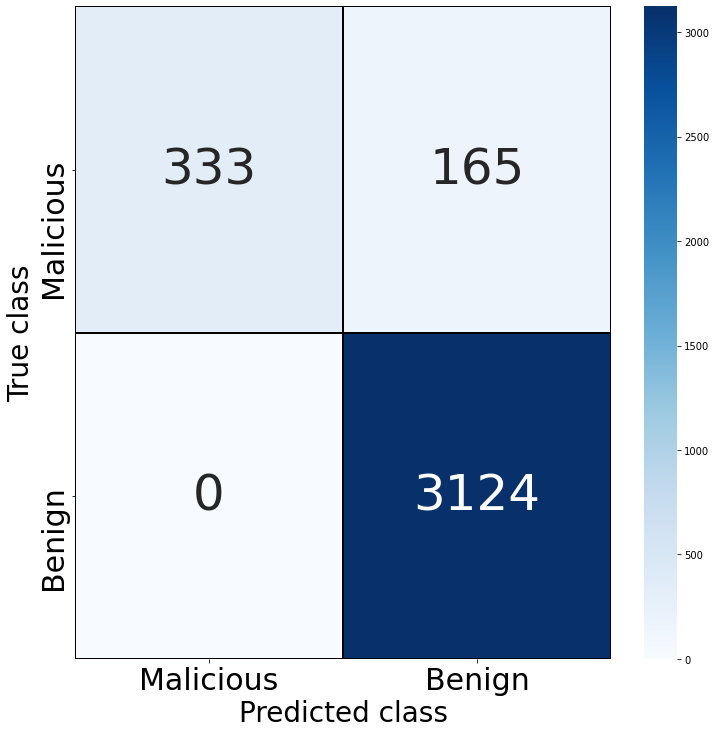

In [ ]:
#0.000211, 0.000054
model = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.001)
model.fit(df_benign_flight_train)

#pickle.dump(model, open('gps-svm.sav', 'wb'))

y_pred = model.predict(df_malicious_flight_pred)
y_true = df_malicious_flight[['label']]

y_true = y_true.replace({'benign': 1})
y_true = y_true.replace('malicious', -1)

#print(model.score_samples(df_malicious_flight_sys_status[['load']])) # get raw scores

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print(conf_matrix)

LABELS = ["Malicious","Benign"]
plt.figure(figsize=(12, 12))
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 50}, fmt="d", cmap="Blues", linewidths=1, linecolor='black');
plt.ylabel('True class', fontsize=28)
plt.xlabel('Predicted class', fontsize=28)
plt.show()

# LOF

Benign count: 3124
Malicious count: 498
Highest acheived macro average F1 was 0.907347 using 2910.000000 neighbours
              precision    recall  f1-score   support

          -1    0.92067   0.76908   0.83807       498
           1    0.96413   0.98944   0.97662      3124

    accuracy                        0.95914      3622
   macro avg    0.94240   0.87926   0.90735      3622
weighted avg    0.95815   0.95914   0.95757      3622

[[ 383  115]
 [  33 3091]]


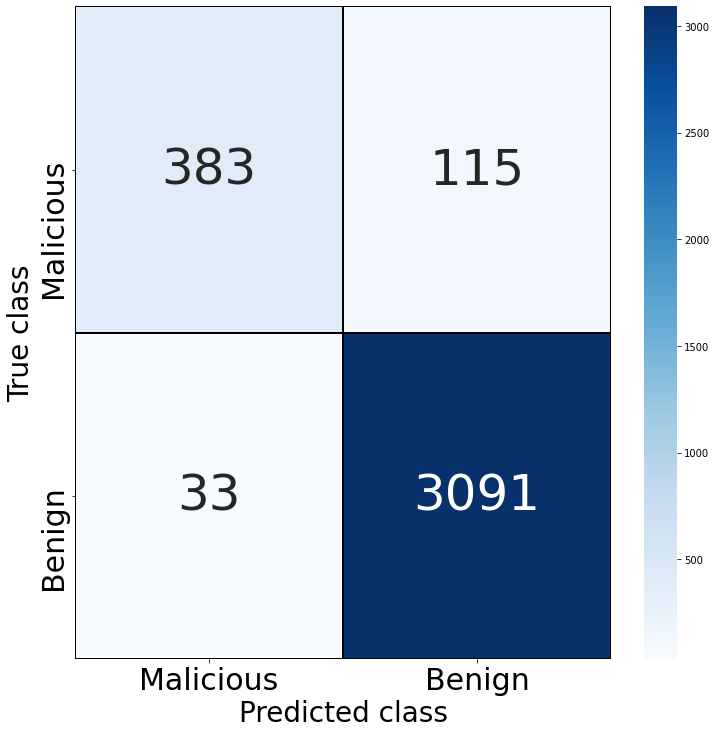

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support as score

print(f"Benign count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'benign'])}")
print(f"Malicious count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'malicious'])}")

neighbours = 0
fscore = 0

for x in np.arange(10, 3000, 100):
  temp_n = x
  model = LocalOutlierFactor(n_neighbors=temp_n, novelty=True, contamination=0.1, n_jobs=-1)
  model.fit(df_benign_flight_train)

  #pickle.dump(model, open('gps-lof.sav', 'wb'))

  y_pred = model.predict(df_malicious_flight_pred)
  y_true = df_malicious_flight[['label']]

  y_true = y_true.replace({'benign': 1})
  y_true = y_true.replace('malicious', -1)

  conf_matrix = metrics.confusion_matrix(y_true, y_pred)
  precision,recall,temp_fscore,support=score(y_true,y_pred,average='macro')

  if temp_fscore > fscore:
    fscore = temp_fscore
    neighbours = temp_n

print("Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbours))
print(metrics.classification_report(y_true, y_pred, digits=5))
print(conf_matrix)

LABELS = ["Malicious","Benign"]
plt.figure(figsize=(12, 12))
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 50}, fmt="d", cmap="Blues", linewidths=1, linecolor='black');
plt.ylabel('True class', fontsize=28)
plt.xlabel('Predicted class', fontsize=28)
plt.show()

# AutoEncoder

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import os

In [ ]:
# load CSVs

df_benign_flight = pd.read_csv( '/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/Benign Flight/CSVs/Condensed/gpsonly.csv')
df_malicious_flight = pd.read_csv('/content/drive/Shareddrives/UAV Security Research/Thesis/Flight Logs/ACE/Visit 2/GPS Spoofing/HackRF/CSVs/Condensed/gpsonly.csv')

df_benign_flight = df_benign_flight.drop(columns=['timestamp','label'])
x = df_benign_flight.values
x = StandardScaler().fit_transform(x) # normalizing the features
print("x after standardizing:\n%s\n" % x[0:5])

train_pca_gps = PCA(.95)
train_pc_data = train_pca_gps.fit_transform(x)
df_benign_flight = pd.DataFrame(data=train_pc_data)


labels = df_malicious_flight[['label']]
df_malicious_flight = df_malicious_flight.drop(columns=['timestamp', 'label'])
x = df_malicious_flight.values
x = StandardScaler().fit_transform(x) # normalizing the features
malicious_data = train_pca_gps.transform(x)
df_malicious_flight = pd.DataFrame(data=malicious_data)
df_malicious_flight['label'] = labels
print(df_malicious_flight.head())


# split benign
df_benign_flight_train, df_benign_flight_test = train_test_split(df_benign_flight, test_size=0.05, random_state=1) # split x% of benign to test RMSE against

# keep only features and label if applicable
#df_benign_flight_train = df_benign_flight_train.drop(columns=['timestamp', 'label'])
# x = df_benign_flight_train.values
# x = StandardScaler().fit_transform(x) # normalizing the features
# train_pca_gps = PCA(.85)
# train_pc_data = train_pca_gps.fit_transform(x)
# df_benign_flight_train = pd.DataFrame(data=train_pc_data)

# print(df_benign_flight_train.head())
# print('Explained variation per principal component: {}'.format(train_pca_gps.explained_variance_ratio_))
# print(sum(train_pca_gps.explained_variance_ratio_))


#df_benign_flight_test = df_benign_flight_test.drop(columns=['timestamp', 'label'])
# x = df_benign_flight_test.values
# x = StandardScaler().fit_transform(x) # normalizing the features
# test_pc_data = train_pca_gps.transform(x)
# df_benign_flight_test = pd.DataFrame(data=test_pc_data)

# print(df_benign_flight_test.head())

labels = df_malicious_flight[['label']]

df_malicious_flight_pred = df_malicious_flight.drop(columns=['label'])
# x = df_malicious_flight_pred.values
# x = StandardScaler().fit_transform(x) # normalizing the features
# malicious_data_test = train_pca_gps.transform(x)
# df_malicious_flight_pred = pd.DataFrame(data=malicious_data_test)
# print(df_malicious_flight_pred.head())


# df_malicious_flight = df_malicious_flight.drop(columns=['timestamp', 'label'])
# x = df_malicious_flight.values
# x = StandardScaler().fit_transform(x) # normalizing the features
# malicious_data = train_pca_gps.transform(x)
# df_malicious_flight = pd.DataFrame(data=malicious_data)
# df_malicious_flight['label'] = labels
# print(df_malicious_flight.head())


df_malicious_flight_test = df_malicious_flight_pred.loc[df_malicious_flight['label'] == 'malicious']

# print the first 5 rows of each dataframe
print("Original Values:\n")
print("df_benign_flight_train:\n%s\n" % df_benign_flight_train[0:5].to_string())
print("df_benign_flight_test:\n%s\n" % df_benign_flight_test[0:5].to_string())
print("df_malicious_flight: \n%s\n" % df_malicious_flight[0:5].to_string())
print("df_malicious_flight_pred: \n%s\n" % df_malicious_flight_pred[0:5].to_string())

x after standardizing:
[[ 3.41799982 -0.37592276 -0.03566225  3.48268502 -1.          1.
   1.         -1.          0.         -1.01936145  0.28696449 -1.82358349
   1.9314988  -0.         -0.85302618 -0.89722187  3.22806002  0.
   0.          3.27948755  0.         -1.70067073 -1.17378513  0.36155779
   2.20026598  2.19995247 -0.55562079  1.21137107 -1.20669512 -0.50365197
  -0.14026192  0.42209436  0.64700133 -0.25364255 -0.53841389  0.14504898
   0.27161024 -0.97664845 -0.68300725  0.          0.          0.
   0.         -0.33970031  0.         -1.         -1.01980125  0.28766349
   1.82337281  0.         -1.          0.          0.17275675 -0.17228634
   0.1055979  -0.0533052   1.         -1.         -1.          0.00911695
  -0.02756686  0.0438114  -3.4517703  -1.          1.         -1.65023519
  -1.07894982 -0.95722592 -0.79789081 -0.67417102  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          3.26550802]
 [ 3

In [ ]:
print(f"Benign count: {len(df_benign_flight_train)}")
print(f"Malicious count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'malicious'])}")

# This is the numeric feature vector, as it goes to the neural net
x_benign_train = df_benign_flight_train.values
x_benign_sample = df_benign_flight_test.values
x_malicious_sample = df_malicious_flight_test.values

model = Sequential()
model.add(Dense(25, input_dim=x_benign_train.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(x_benign_train.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor="loss", min_delta=1e-3, restore_best_weights=True)
model.fit(x_benign_train,x_benign_train,verbose=1,epochs=100,callbacks=[monitor])

#model.save('gps-ae.sav')

pred = model.predict(x_benign_train)
score1 = metrics.mean_squared_error(pred,x_benign_train)
pred = model.predict(x_benign_sample)
score2 = metrics.mean_squared_error(pred,x_benign_sample)
pred = model.predict(x_malicious_sample)
score3 = metrics.mean_squared_error(pred,x_malicious_sample)
print(f"Insample Benign Score (MSE): {score1}")
print(f"Out of Sample Benign Score (MSE): {score2}")
print(f"Malicious Score (MSE): {score3}")

Benign count: 5774
Malicious count: 498
Epoch 1/100
181/181 [==============================] - 1s 2ms/step - loss: 1.9130
Insample Benign Score (MSE): 1.5189947250717644
Out of Sample Benign Score (MSE): 1.6476457797270243
Malicious Score (MSE): 8.164580766692307


Highest acheived macro average F1 was 0.908066 using a threshold of 82.300000%
Selected threshold: 82.30000000000047%
Calculated MSE threshold: 1.8283214963909684
Malicious count: 641
              precision    recall  f1-score   support

          -1    0.74727   0.96185   0.84109       498
           1    0.99363   0.94814   0.97035      3124

    accuracy                        0.95003      3622
   macro avg    0.87045   0.95500   0.90572      3622
weighted avg    0.95975   0.95003   0.95258      3622

[[ 479   19]
 [ 162 2962]]


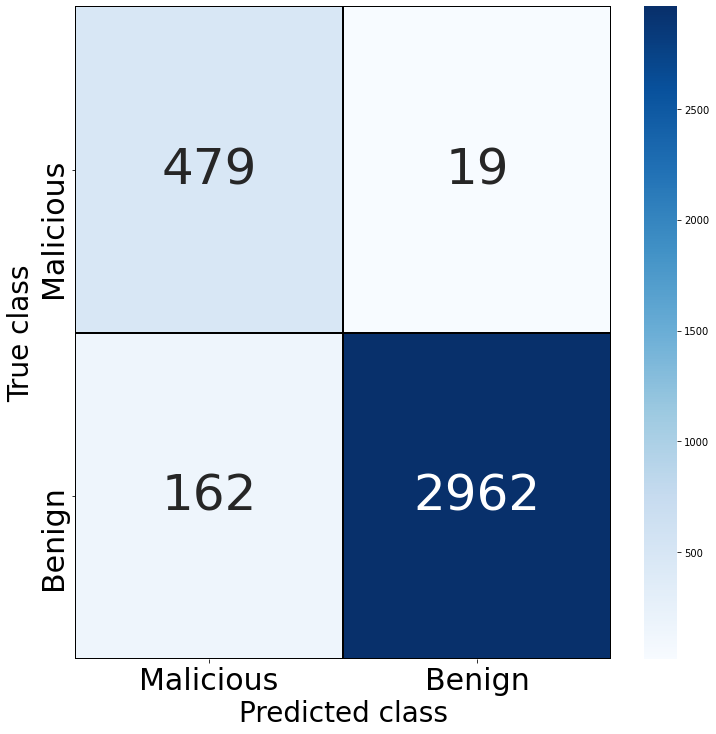

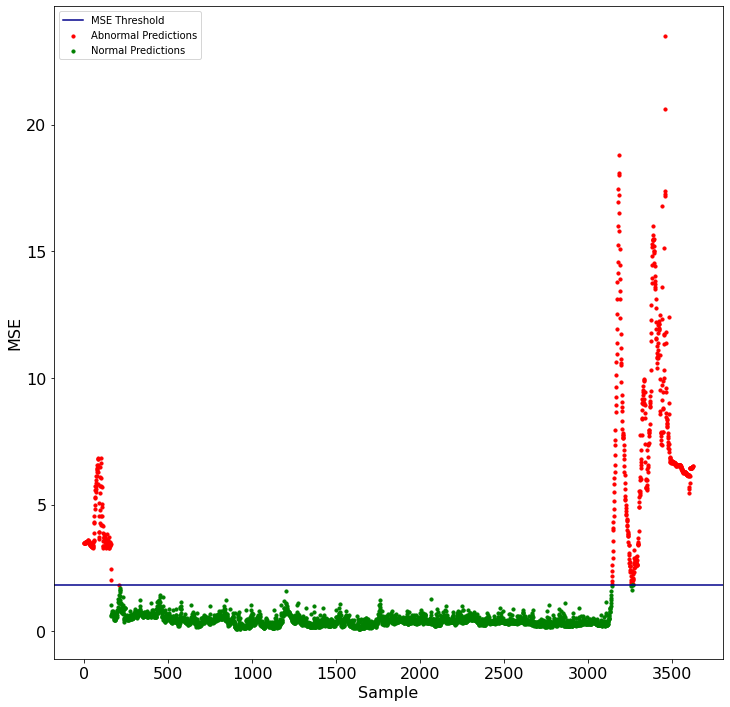

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

threshold = 0
fscore = 0

for x in np.arange(50, 100, 0.1):
  temp_t = x
  y_pred = pd.DataFrame()

  predicted = model.predict(df_malicious_flight_pred)
  mse = np.mean(np.power(df_malicious_flight_pred - predicted, 2), axis=1)
  y_pred['MSE'] = mse
  mse_threshold = np.quantile(y_pred['MSE'], (threshold/100))
  y_pred['label'] = 1
  y_pred.loc[y_pred['MSE'] > mse_threshold, 'label'] = -1

  y_true = df_malicious_flight[['label']]
  y_true = y_true.replace({'benign': 1})
  y_true = y_true.replace('malicious', -1)

  conf_matrix = confusion_matrix(y_true, y_pred['label'])
  precision,recall,temp_fscore,support=score(y_true,y_pred['label'],average='macro')
  if temp_fscore > fscore:
    fscore = temp_fscore
    threshold = temp_t

print("Highest acheived macro average F1 was %f using a threshold of %f%%" % (fscore, threshold))
print(f'Selected threshold: {threshold}%')
print(f'Calculated MSE threshold: {mse_threshold}')
print(f"Malicious count: {len(y_pred.loc[y_pred['label'] == -1])}")
print(classification_report(y_true, y_pred['label'], digits=5))
print(conf_matrix)

LABELS = ["Malicious","Benign"]
plt.figure(figsize=(12, 12))
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 50}, fmt="d", cmap="Blues", linewidths=1, linecolor='black');
plt.ylabel('True class', fontsize=28)
plt.xlabel('Predicted class', fontsize=28)
plt.show()

y_mse = y_pred['MSE']
y_mse_benign = np.ma.masked_where(y_mse > mse_threshold, y_mse)
y_mse_malicious = np.ma.masked_where(y_mse <= mse_threshold, y_mse)
plt.figure(figsize=(12, 12))
x_sample = np.arange(0,len(y_mse_malicious))

s = 10
plt.scatter(x_sample, y_mse_malicious, c='r', s=s, label='Abnormal Predictions')
plt.scatter(x_sample, y_mse_benign, c='g', s=s, label='Normal Predictions')
plt.axhline(y=mse_threshold, c='darkblue', linestyle='-', label='MSE Threshold')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Sample', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.show()

# Isolation Forest

In [ ]:
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest

Benign count: 11105
Malicious count: 1710


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (10000) is greater than the total number of samples (5928). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


              precision    recall  f1-score   support

          -1    0.00000   0.00000   0.00000      1710
           1    0.86626   0.99739   0.92721     11105

    accuracy                        0.86430     12815
   macro avg    0.43313   0.49869   0.46361     12815
weighted avg    0.75067   0.86430   0.80349     12815

[[    0  1710]
 [   29 11076]]


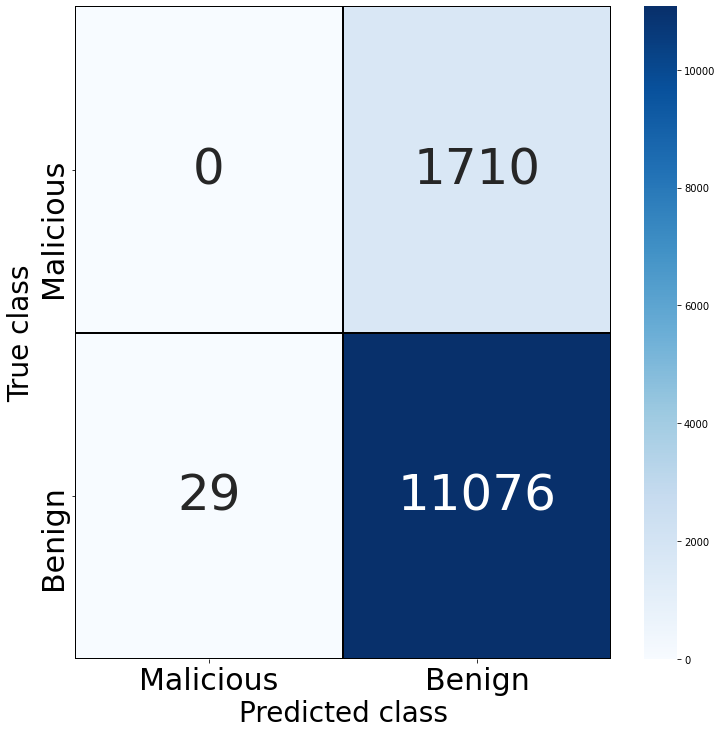

In [ ]:
print(f"Benign count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'benign'])}")
print(f"Malicious count: {len(df_malicious_flight.loc[df_malicious_flight['label'] == 'malicious'])}")

outlier_fraction = 0 # 0 for one-class classification

model = IsolationForest(behaviour='new', n_estimators=20, max_samples=10000, contamination=outlier_fraction, random_state=101, max_features=(len(df_benign_flight_train.columns)))
model.fit(df_benign_flight_train)

#pickle.dump(model, open('finalized_model.sav', 'wb'))

y_pred = model.predict(df_malicious_flight_pred)
y_true = df_malicious_flight[['label']]

y_true = y_true.replace({'benign': 1})
y_true = y_true.replace('malicious', -1)

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print(conf_matrix)

LABELS = ["Malicious","Benign"]
plt.figure(figsize=(12, 12))
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 50}, fmt="d", cmap="Blues", linewidths=1, linecolor='black');
plt.ylabel('True class', fontsize=28)
plt.xlabel('Predicted class', fontsize=28)
plt.show()

In [ ]:
print(df_benign_flight_train)
print(df_malicious_flight_pred)
print(y_true)

                0          1          2   ...        20        21        22
0       144.964758  97.816281  14.164605  ... -5.071291 -0.880663 -2.047446
1       144.964758  97.816281  14.164605  ... -5.071291 -0.880663 -2.047446
2       144.964758  97.816281  14.164605  ... -5.071291 -0.880663 -2.047446
3       144.964758  97.816281  14.164605  ... -5.071291 -0.880663 -2.047446
4       144.964758  97.816281  14.164605  ... -5.071291 -0.880663 -2.047446
...            ...        ...        ...  ...       ...       ...       ...
326849   17.891274 -19.579945  -0.191148  ...  1.835724  1.148915  0.458711
326850   17.820682 -19.390405  -0.185417  ...  1.783323  1.102376  0.471267
326851   17.656125 -18.945696  -0.173195  ...  1.657277  0.996488  0.485047
326852   17.747449 -19.193218  -0.186269  ...  1.729163  1.094877  0.446993
326853   17.616987 -18.844455  -0.169083  ...  1.633353  0.988591  0.509472

[326854 rows x 23 columns]
                0          1          2   ...        20     